<a href="https://colab.research.google.com/github/SanghunOh/study_machinglearning/blob/main/codes/sanghunoh/reports/%EA%B3%BC%EC%A0%9C_4_2_COIL20_PCA_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##2. (60점) 첨부된 COIL20 데이터(Columbia Object Image Library, HW4_COIL20.mat)에 대한 특징 추출 및 2차원 출력을 수행하기 위한 시스템을 구성하시오.

In [1]:
# !wget https://github.com/SanghunOh/study_machinglearning/blob/main/datas/HW4_COIL20.mat
!ls

HW4_COIL20.mat	sample_data


In [2]:
!pip install mat73

In [3]:
# read features and labels from dataset file(mat)
import mat73
mat_contents = mat73.loadmat('./HW4_COIL20.mat')
type(mat_contents), mat_contents.keys(),
features = mat_contents['X']
labels = mat_contents['Y']

import numpy as np
Nclass = np.unique(labels).shape[0]
rows, cols = np.unique(labels, return_counts=True)
# Nclass
features.shape, labels.shape, rows, cols

((280, 1024),
 (280,),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20.]),
 array([14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14]))

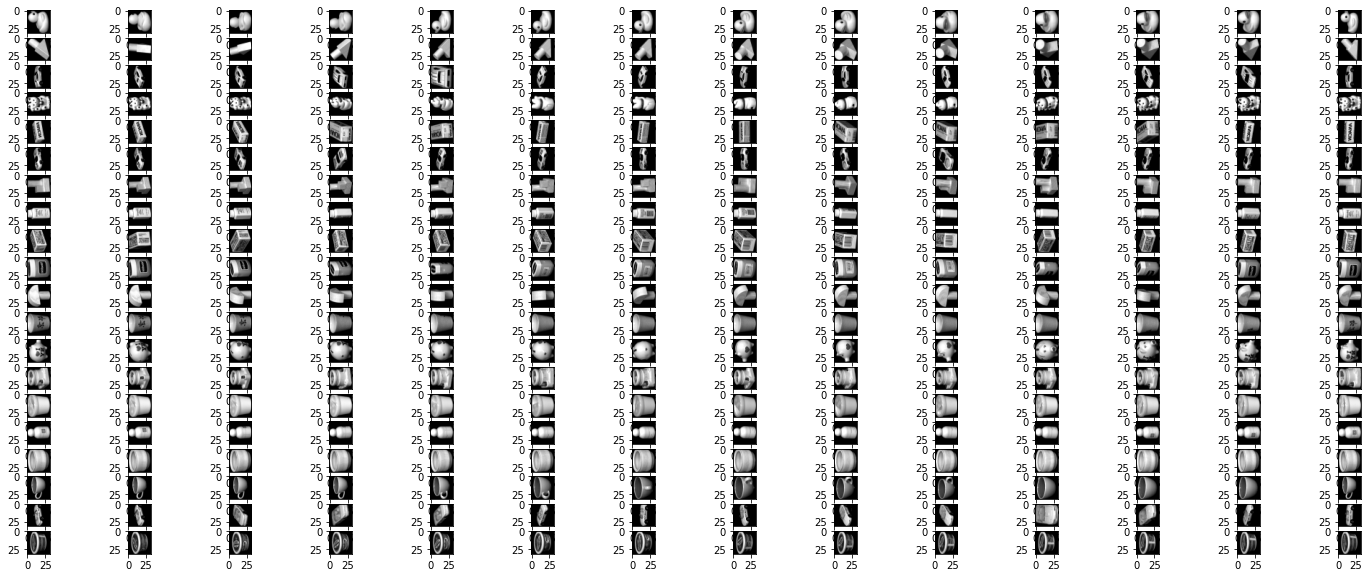

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25,10))

for idx in range(features.shape[0]):
  plt.subplot(rows.shape[-1], cols[0], idx+1)
  plt.imshow(np.reshape(features[idx,:], (32,32)), cmap='gray')

##PCA(Principal Component Analysis)

###Centering Data

In [5]:
import numpy.matlib
rows = features.shape[0]
features_means = np.matlib.repmat(np.mean(features,axis=0), rows, 1)
features_cov = 1/rows * (features-features_means) @ (features-features_means).T
features_means.shape, features_cov.shape

((280, 1024), (280, 280))

###Computing the Eigenvectors and Eigenvalues

In [6]:
eigen_vectors_pca, eigen_values_pca, U = np.linalg.svd(features_cov)
eigen_values_pca.shape, eigen_vectors_pca.shape, U.shape
# features_std_sigma, eigen_values_pca, eigen_vectors_pca

((280,), (280, 280), (280, 280))

In [7]:
# 벡터별 정보 보유율
eigen_values_pca_sum = sum(eigen_values_pca)
threshold = 0.95
extracted_dim = 0
for idx in range(rows):
  projected_rate = sum(eigen_values_pca[0:idx])/eigen_values_pca_sum
  if projected_rate >= threshold:
    print('index {}, rate:{:.2f}'.format(idx, projected_rate*100))
    extracted_dim = idx
    break

index 61, rate:95.10


###95% 이상 되는 차원 추출

In [8]:
features_pca = (features - features_means).T @ eigen_vectors_pca
Wq, Wr = np.linalg.qr(features_pca[:,0:extracted_dim])
extracted_features = (Wq.T @ features.T).T
features_pca.shape, Wq.shape, Wr.shape, extracted_features.shape

((1024, 280), (1024, 61), (61, 61), (280, 61))

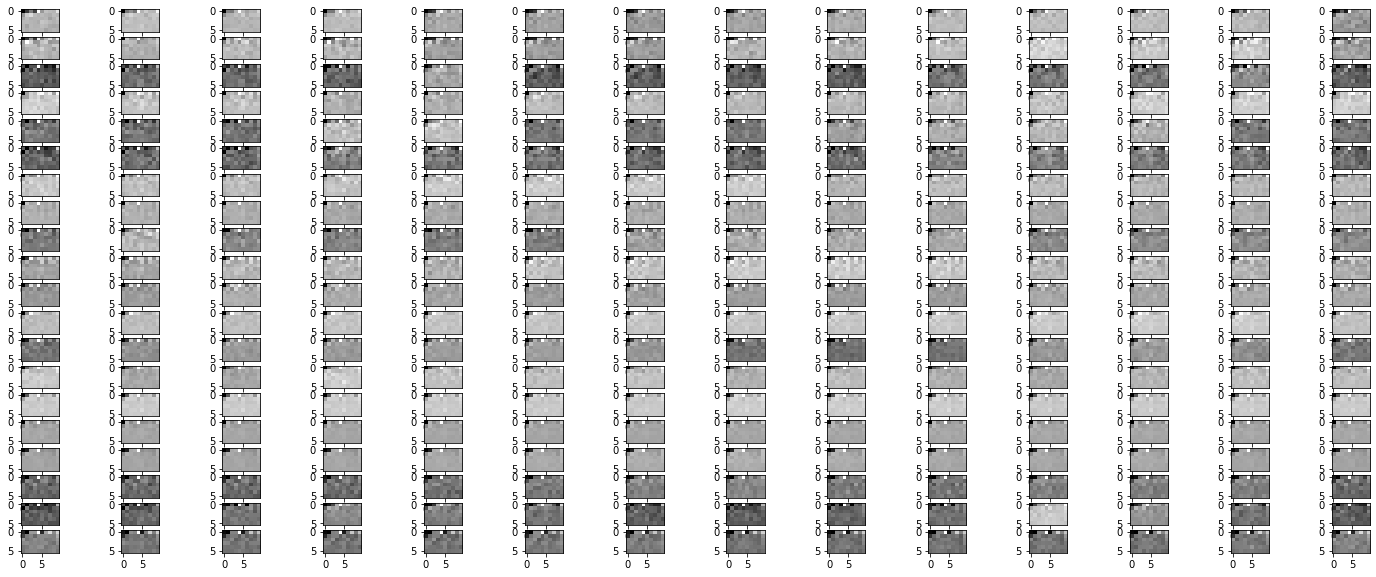

In [9]:
plt.figure(figsize=(25,10))

for i in range(rows):
  plt.subplot(20, 14, i+1)
  plt.imshow(np.reshape(extracted_features[i,0:60], (6,10)), cmap='gray')

###2차원 Projectioin 표시

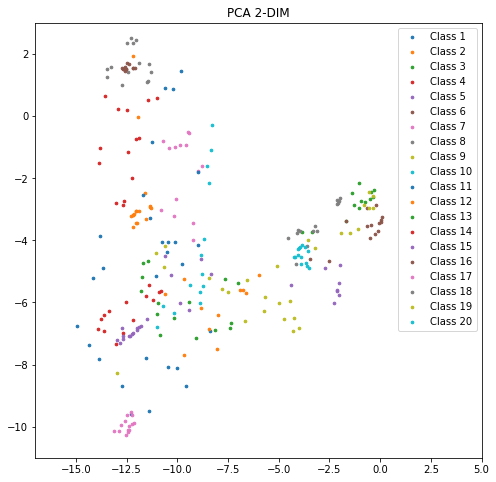

In [10]:
Wo2dim, Wi2dim= np.linalg.qr(features_pca[:,0:2])
Ytrain2dim = (Wo2dim.T @ features.T).T

plt.figure(figsize=(8,8))
plt.axis([-17,5,-11,3])
for i in range(Nclass):
  plt.scatter(Ytrain2dim[i*14:i*14+14,0], Ytrain2dim[i*14:i*14+14,1],  label= "Class {}".format(i+1), s =7)
plt.title("PCA 2-DIM") #타이틀
plt.legend(loc = 'upper right') #라벨 호출및 위치
plt.show()

##LDA 분석

###Class별 공분산

In [11]:
#클래스내 공분산 계산 (within scatter matrix) / = (클레스별공분산*클레스별데이터수) + (클레스별공분산*클레스별데이터수) + ...
cless_matrix = np.zeros([rows, extracted_dim])

Sw = np.zeros([extracted_dim, extracted_dim]) #PCA에서 걸러낸 차원 크기의 빈행렬을 만들어준다
for i in range(Nclass):
  cless_matrix_temp = extracted_features[i*14:(i+1)*14,:] #클래스별 데이터 묶음 추출
  Sw = Sw + 14*np.cov(cless_matrix_temp, rowvar=False)
  cless_matrix[i,:] = np.mean(cless_matrix_temp, axis=0)

cless_matrix.shape, Sw.shape

((280, 61), (61, 61))

In [12]:
#클래스별 공분산 계산 (between Scatter Matrix) / = (클래스수) * (각클래스별평균집합의 공분산)
Sb = rows * np.cov(cless_matrix, rowvar=False)

Sb.shape

(61, 61)

###LDA 고유치 (svd(클래스내 공분산역원 * 클래스별공분산)) 특징 추출

In [13]:
Jcov = np.dot(np.linalg.inv(Sw),Sb)
eigen_vectors_lda, eigen_values_lda, U = np.linalg.svd(Jcov)
eigen_values_lda.shape, eigen_vectors_lda.shape, U.shape

((61,), (61, 61), (61, 61))

In [14]:
Ztrain = (eigen_vectors_lda[:,0:(rows-1)].T @ extracted_features.T).T 

Ztrain.shape,

((280, 61),)

###2차원 Projectioin 표시

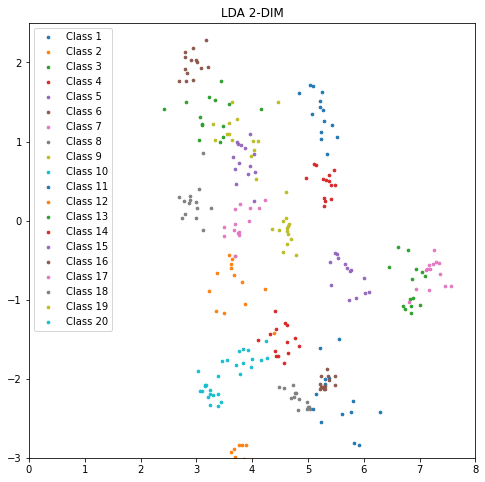

In [15]:
Ztrain2dim = (eigen_vectors_lda[:,0:2].T @ extracted_features.T).T 

plt.figure(figsize=(8,8))
plt.axis([0,8,-3,2.5])
for i in range(Nclass):
  plt.scatter(Ztrain2dim[i*14:i*14+14,0], Ztrain2dim[i*14:i*14+14,1],  label= "Class {}".format(i+1), s =7)
plt.title("LDA 2-DIM") #타이틀
plt.legend(loc = 'upper left') #라벨 호출및 위치
plt.show()